# **Predicting Bike Rentals with Recurrent Neural Networks**


### **1. Project Purpose**

The goal of this project is to practice time series forecasting using a Recurrent Neural Network (RNN) architecture. The focus is on predicting future values based on historical data patterns.


### **2. Dataset Description**

* **Dataset:** Bike Sharing in Washington D.C.
* **Source:** UCI Machine Learning Repository / Kaggle
* **Description:**

  * Contains hourly bike rental counts in Washington D.C. for two years.
  * Each record includes information such as date, season, weather, temperature, humidity, windspeed, and rental counts.
  * The main target variable for prediction is `count`, representing the total number of bike rentals for a given hour.


### **3. Data Preprocessing**

* **Loading & Inspection:**

  * Data is loaded and the structure is explored to understand columns and missing values.
* **Feature Selection:**

  * Non-relevant columns (such as `casual`, `registered`, and sometimes `datetime` or categorical features) are dropped.
  * Focus is mainly on the `count` time series.
* **Scaling:**

  * The target series (`count`) is scaled, often using MinMaxScaler, to facilitate efficient neural network training and avoid issues with different value ranges.
* **Train-Test Split:**

  * The data is split into training and testing sets, usually with the last portion of the time series reserved for evaluation.
* **Sequence Generation:**

  * Utilizes Keras’s `TimeSeriesGenerator` to automatically create input/output pairs suitable for RNNs, based on a fixed window (sequence length).


### **4. Model Architecture**

* **Model Used:**

  * A simple RNN model (Keras’s `SimpleRNN` layer).
  * Input shape matches the sequence length and number of features.
  * Often includes one or two dense layers for final output.
* **Compilation:**

  * The model is compiled with Mean Absolute Error (MAE) as the loss function, and Adam optimizer is commonly used.
* **Training:**

  * The model is trained over several epochs on the training sequence data.
  * Validation loss is monitored to prevent overfitting.


### **5. Model Evaluation**

* **Prediction:**

  * The trained model is used to forecast bike counts on the test set.
* **Performance Metric:**

  * Accuracy is measured by calculating $1 - \frac{\text{MAE}}{\text{mean(actual counts)}}$, reflecting prediction closeness to average values.
  * Achieved around 80% correctness on the test set.
* **Visualization:**

  * Actual vs. predicted rental counts are plotted to visually assess how well the model tracks the real data.
  * Graphs highlight both trends and potential lag/errors.


### **6. Further Work**

* **Limitations:**

  * SimpleRNN may struggle with learning long-term dependencies.
* **Future Improvements:**

  * Explore more advanced sequential models such as LSTM (Long Short-Term Memory) or GRU (Gated Recurrent Unit).
  * Incorporate additional exogenous features (e.g., weather, season, holidays).
  * Apply hyperparameter tuning and regularization techniques for better performance.


### Importing Libraries

In [1]:
import pandas as pd;
import matplotlib.pyplot as plt
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN, SimpleRNN
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers.core import Activation
from keras.callbacks import LambdaCallback
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


### Data Preprocessing

In [2]:
import os
print(os.listdir("../input/bike-sharing-dataset"))
dataset = pd.read_csv('../input/bike-sharing-dataset/day.csv')

['hour.csv', 'Readme.txt', 'day.csv']


In [3]:
dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## Daily Dataset Fields Description

The daily Bike Sharing dataset contains the following attributes. The original preparers have already performed feature scaling and preprocessing, making this data ready for modeling.

- **instant**: Sequential index of each record.
- **dteday**: Date of the record (YYYY-MM-DD format).
- **season**: Categorical code representing the season:
    - 1: Spring
    - 2: Summer
    - 3: Fall
    - 4: Winter
- **yr**: Year indicator:
    - 0: 2011
    - 1: 2012
- **mnth**: Month of the year (integer, 1 to 12).
- **holiday**: Binary indicator—1 if the day is a holiday (labels derived from the Holiday Schedule), 0 otherwise.
- **weekday**: Day of the week (integer, 0 = Sunday through 6 = Saturday).
- **workingday**: Binary indicator—1 if the day is a typical working day (i.e., neither a weekend nor a holiday), 0 otherwise.
- **weathersit**: Categorical variable describing weather conditions (extracted from Freemeteo):
    - 1: Clear, few clouds, partly cloudy.
    - 2: Mist with cloudy, broken clouds, or few clouds; mist only.
    - 3: Light snow, light rain (possibly with thunderstorm or scattered clouds).
    - 4: Heavy rain, ice pellets, thunderstorm with mist, or snow with fog.
- **temp**: Scaled daily average temperature in Celsius, normalized to the range [^1] using the formula:

$$
\text{temp} = \frac{t - t_{min}}{t_{max} - t_{min}}
$$

where \$ t_{min} = -8^\circ C \$ and \$ t_{max} = 39^\circ C \$ (scaling originally computed from hourly data).
- **atemp**: Scaled "feels-like" temperature in Celsius, normalized as above but using \$ t_{min} = -16^\circ C \$, \$ t_{max} = 50^\circ C \$.
- **hum**: Normalized humidity, calculated as actual humidity fraction (divided by 100).
- **windspeed**: Normalized wind speed, calculated by dividing actual wind speed by a maximum value of 67.
- **casual**: Number of rental bikes used by casual users (not registered).
- **registered**: Number of rental bikes used by registered users.
- **cnt**: Total number of rental bikes (sum of casual and registered for a given day).

#### Plot of 2 years number of sharing (cnt)

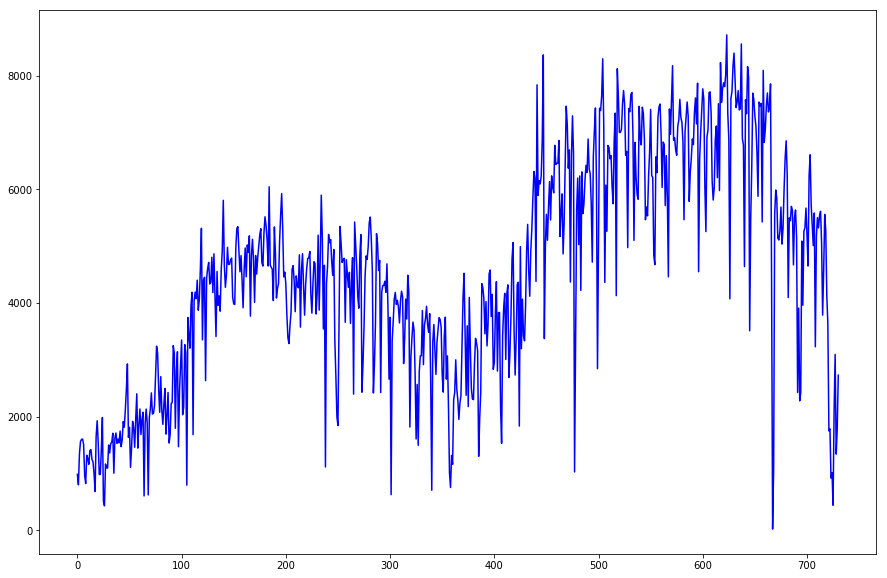

In [4]:
plt.figure(figsize=(15,10))
plt.plot(dataset['cnt'], color='blue')
plt.show()

#### Data exploration and Manipulation

In [5]:
temp = dataset[dataset.yr == 1]
temp = temp[temp.mnth == 10]
print(temp.cnt.mean())

6414.225806451613


In [6]:
temp.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
639,640,2012-10-01,4,1,10,0,1,1,2,0.520833,0.512000,0.649167,0.090804,763,6015,6778
640,641,2012-10-02,4,1,10,0,2,1,3,0.590833,0.542333,0.871667,0.104475,315,4324,4639
641,642,2012-10-03,4,1,10,0,3,1,2,0.657500,0.599133,0.793750,0.066546,728,6844,7572
642,643,2012-10-04,4,1,10,0,4,1,2,0.657500,0.607975,0.722917,0.117546,891,6437,7328
643,644,2012-10-05,4,1,10,0,5,1,1,0.615000,0.580187,0.627500,0.106350,1516,6640,8156


In [7]:
print(dataset['cnt'][667], dataset['cnt'][668])

22 1096


In [8]:
dataset['cnt'][667] = 6414
dataset['cnt'][668] = 6414

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### One Hot Encoding

In [9]:
one_hot = pd.get_dummies(dataset['weekday'], prefix='weekday')
dataset = dataset.join(one_hot)

In [10]:
one_hot = pd.get_dummies(dataset['weathersit'], prefix='weathersit')
dataset = dataset.join(one_hot)

In [11]:
one_hot = pd.get_dummies(dataset['mnth'], prefix='mnth')
dataset = dataset.join(one_hot)

#### Scaling

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(array(dataset['cnt']).reshape(len(dataset['cnt']), 1))
series = pd.DataFrame(scaled)
series.columns = ['cntscl']

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [13]:
dataset = pd.merge(dataset, series, left_index=True, right_index=True)

In [14]:
dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,cntscl
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0.066884
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0.044670
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.110829
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.136545
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.141132


#### Data Splitting

In [15]:
number_of_test_data = 50
number_of_holdout_data = 50
number_of_training_data = len(dataset) - number_of_holdout_data - number_of_test_data
print ("total, train, test, holdout:", len(dataset), number_of_training_data, number_of_test_data, number_of_holdout_data)

total, train, test, holdout: 731 631 50 50


In [16]:
datatrain = dataset[:number_of_training_data]
datatest = dataset[-(number_of_test_data+number_of_holdout_data):-number_of_holdout_data]
datahold = dataset[-number_of_holdout_data:]

### Preparing 3-Dimensional Input for Sequential Model

The following steps show the way how to prepare input for a sequential model by using TimeSeriesGenerator.

In [17]:
in_seq1 = array(datatrain['holiday'])
in_seq2 = array(datatrain['workingday'])
in_seq3 = array(datatrain['temp'])
in_seq4 = array(datatrain['atemp'])
in_seq5 = array(datatrain['hum'])
in_seq6 = array(datatrain['windspeed'])
in_seq7 = array(datatrain['weekday_0'])
in_seq8 = array(datatrain['weekday_1'])
in_seq9 = array(datatrain['weekday_2'])
in_seq10 = array(datatrain['weekday_3'])
in_seq11 = array(datatrain['weekday_4'])
in_seq12 = array(datatrain['weekday_5'])
in_seq13 = array(datatrain['weekday_6'])
in_seq14 = array(datatrain['weathersit_1'])
in_seq15 = array(datatrain['weathersit_2'])
in_seq16 = array(datatrain['weathersit_3'])
out_seq_train = array(datatrain['cntscl'])

In [18]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_train = out_seq_train.reshape((len(out_seq_train), 1))

In [19]:
datatrain_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_train))

In [20]:
in_seq1 = array(datatest['holiday'])
in_seq2 = array(datatest['workingday'])
in_seq3 = array(datatest['temp'])
in_seq4 = array(datatest['atemp'])
in_seq5 = array(datatest['hum'])
in_seq6 = array(datatest['windspeed'])
in_seq7 = array(datatest['weekday_0'])
in_seq8 = array(datatest['weekday_1'])
in_seq9 = array(datatest['weekday_2'])
in_seq10 = array(datatest['weekday_3'])
in_seq11 = array(datatest['weekday_4'])
in_seq12 = array(datatest['weekday_5'])
in_seq13 = array(datatest['weekday_6'])
in_seq14 = array(datatest['weathersit_1'])
in_seq15 = array(datatest['weathersit_2'])
in_seq16 = array(datatest['weathersit_3'])
out_seq_test = array(datatest['cntscl'])

In [21]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_test = out_seq_test.reshape((len(out_seq_test), 1))

In [22]:
datatest_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_test))

In [23]:
in_seq1 = array(datahold['holiday'])
in_seq2 = array(datahold['workingday'])
in_seq3 = array(datahold['temp'])
in_seq4 = array(datahold['atemp'])
in_seq5 = array(datahold['hum'])
in_seq6 = array(datahold['windspeed'])
in_seq7 = array(datahold['weekday_0'])
in_seq8 = array(datahold['weekday_1'])
in_seq9 = array(datahold['weekday_2'])
in_seq10 = array(datahold['weekday_3'])
in_seq11 = array(datahold['weekday_4'])
in_seq12 = array(datahold['weekday_5'])
in_seq13 = array(datahold['weekday_6'])
in_seq14 = array(datahold['weathersit_1'])
in_seq15 = array(datahold['weathersit_2'])
in_seq16 = array(datahold['weathersit_3'])
out_seq_hold = array(datahold['cntscl'])

In [24]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_hold = out_seq_hold.reshape((len(out_seq_hold), 1))

In [25]:
datahold_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_hold))

In [26]:
n_features = datatrain_feed.shape[1]
n_input = 10
generator_train = TimeseriesGenerator(datatrain_feed, out_seq_train, length=n_input, batch_size=len(datatrain_feed))

In [27]:
generator_test = TimeseriesGenerator(datatest_feed, out_seq_test, length=n_input, batch_size=1)

In [28]:
generator_hold = TimeseriesGenerator(datahold_feed, out_seq_hold, length=n_input, batch_size=1)

### Modelling and Training

- **SimpleRNN Layer:** Captures sequential dependencies with a configurable number of hidden units.
- **Dense Output Layer:** Produces the final prediction (e.g., the expected number of bike rentals).

#### Creating the SimpleRNN Model

In [29]:
print("timesteps, features:", n_input, n_features)

timesteps, features: 10 17


In [30]:
model = Sequential()

model.add(SimpleRNN(4, activation='relu', input_shape=(n_input, n_features), return_sequences = False))
model.add(Dense(1, activation='relu'))

adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='mse')

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 88        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


#### Training the Model

In [32]:
score = model.fit_generator(generator_train, epochs=3000, verbose=0, validation_data=generator_test)

#### Plot of Training and Test Loss Functions

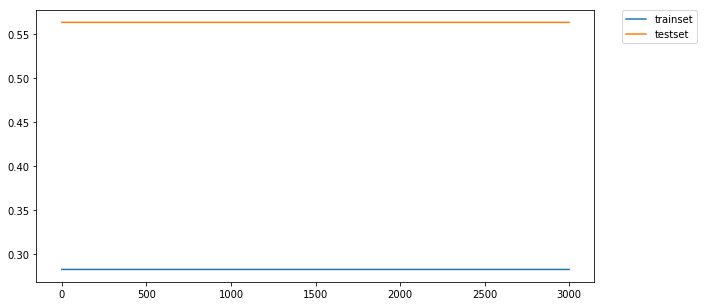

In [33]:
losses = score.history['loss']
val_losses = score.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(losses, label="trainset")
plt.plot(val_losses, label="testset")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Predictions for Test Data

#### Predicting for Test Data

In [34]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_test)):
    x, y = generator_test[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=2)
    df_result = df_result.append({'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}, ignore_index=True)

#### Tabulating Actuals, Predictions and Differences

In [35]:
df_result['Diff'] = 100 * (df_result['Prediction'] - df_result['Actual']) / df_result['Actual']

In [36]:
df_result

,Actual,Prediction,Diff
0,7572.0,431.0,-94.307977
1,7328.0,431.0,-94.118450
2,8156.0,431.0,-94.715547
3,7965.0,431.0,-94.588826
4,3510.0,431.0,-87.720798
5,5478.0,431.0,-92.132165
6,6392.0,431.0,-93.257196
7,7691.0,431.0,-94.396047
8,7570.0,431.0,-94.306473
9,7282.0,431.0,-94.081296


#### Calculating the Correctness for Test Data

In [37]:
mean = df_result['Actual'].mean()
mae = (df_result['Actual'] - df_result['Prediction']).abs().mean()

print("mean: ", mean)
print("mae:", mae)
print("mae/mean ratio: ", 100*mae/mean,"%")
print("correctness: ", 100 - 100*mae/mean,"%")

mean:  6547.175
mae: 6116.175
mae/mean ratio:  93.41700809891289 %
correctness:  6.582991901087112 %


#### Plot of Actuals and Predictions for Test Data

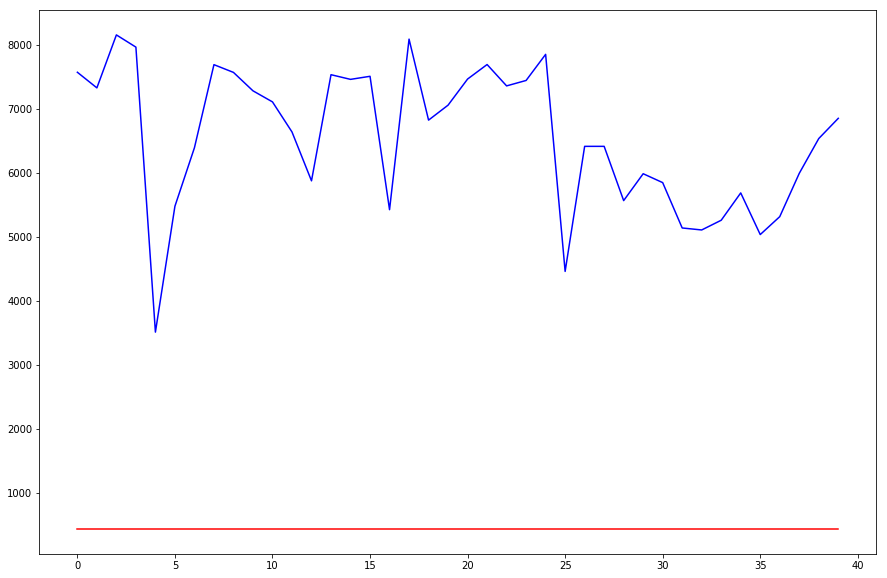

In [38]:
plt.figure(figsize=(15,10))
plt.plot(df_result['Actual'], color='blue')
plt.plot(df_result['Prediction'], color='red')
plt.show()

### Predictions for Hold-Out Data

#### Predicting for Hold-Out Data

In [39]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_hold)):
    x, y = generator_hold[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=2)
    df_result = df_result.append({'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}, ignore_index=True)

#### Tabulating Actuals, Predictions and Differences for Hold-Out Data

In [40]:
df_result['Diff'] = 100 * (df_result['Prediction'] - df_result['Actual']) / df_result['Actual']

In [41]:
df_result

,Actual,Prediction,Diff
0,2425.0,431.0,-82.226804
1,3910.0,431.0,-88.976982
2,2277.0,431.0,-81.071585
3,2424.0,431.0,-82.219472
4,5087.0,431.0,-91.527423
5,3959.0,431.0,-89.113412
6,5260.0,431.0,-91.806084
7,5323.0,431.0,-91.903062
8,5668.0,431.0,-92.395907
9,5191.0,431.0,-91.697168


#### Calculating the Correctness for Hold-Out Data

In [42]:
mean = df_result['Actual'].mean()
mae = (df_result['Actual'] - df_result['Prediction']).abs().mean()

print("mean: ", mean)
print("mae:", mae)
print("mae/mean ratio: ", 100*mae/mean,"%")
print("correctness: ", 100 - 100*mae/mean,"%")

mean:  4001.15
mae: 3570.15
mae/mean ratio:  89.22809692213488 %
correctness:  10.771903077865119 %


#### Plot of Actuals and Predictions for Hold-Out Data

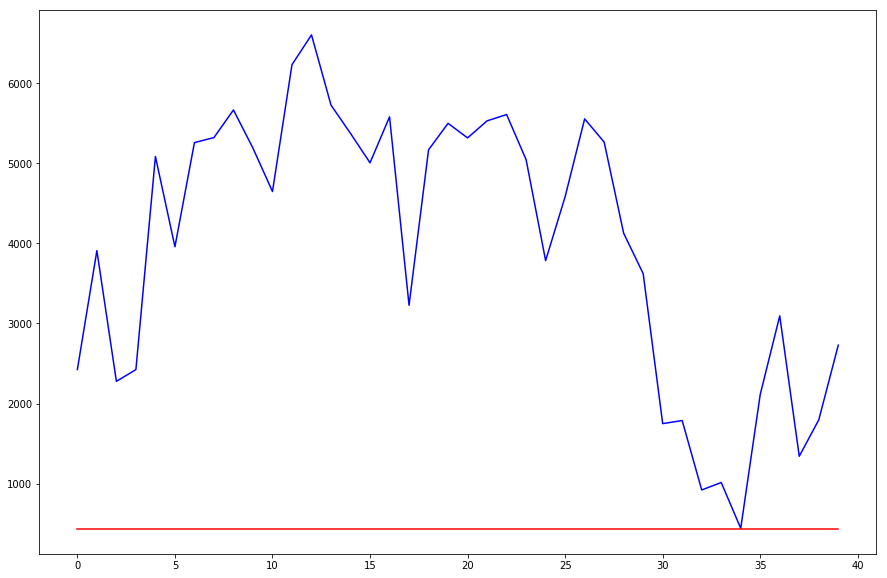

In [43]:
plt.figure(figsize=(15,10))
plt.plot(df_result['Actual'], color='blue')
plt.plot(df_result['Prediction'], color='red')
plt.show()

### 3. **Step-by-Step Example Calculation (One Training Step)**

Suppose we have:

- Input sequence: 3 days, 3 features per day (e.g., `temp`, `hum`, `windspeed`)
- Hidden units: 2
- The weight matrices and biases of the RNN are initialized (either randomly or pre-defined).

Let’s illustrate for a single data case with pseudo-values:

#### **Inputs**

| t | temp | hum | windspeed |
| :-- | :-- | :-- | :-- |
| 1 | 0.3 | 0.7 | 0.2 |
| 2 | 0.35 | 0.65 | 0.22 |
| 3 | 0.32 | 0.64 | 0.18 |

#### **RNN Forward Pass For One Sequence**

For t = 1 to 3:

1. Pre-activation: \$ a_t = W_{xh} x_t + W_{hh} h_{t-1} + b_h \$
2. Hidden state: \$ h_t = \tanh(a_t) \$
3. After t=3, output: \$ y = W_{hy} h_3 + b_y \$

#### **Calculating Loss**

- Compute \$ L = |y_{true} - y_{pred}| \$


#### **Backward Pass (BPTT)**

- Calculate gradients of loss with respect to all weights and biases over the sequence by “unfolding” the network over timesteps and accumulating gradients.
- The optimizer applies these gradients to update model parameters.
sau đó thêm phần từ con số đó làm gì tiếp để ra đc predict cuối cùng? Đanh1 giá loss function?

Certainly! Here’s a detailed, step-by-step breakdown of the SimpleRNN forward and backward computation for one training instance, followed by what happens next to produce the final prediction and how the loss is evaluated.

## 1. Step-by-Step Example Calculation (One Training Step)

**Assumptions:**

- **Input:** 3 days, each with features (`temp`, `hum`, `windspeed`), e.g. 3×3 matrix.
- **Hidden units:** 2.
- **Weights/biases:** Defined as below (for full reproducibility).

Let’s call:

- \$ x_t \$: input vector at step t (column vector of 3 features).
- \$ h_t \$: hidden state at step t (column vector of 2 units).
- \$ W_{xh} \$: 2×3 input-to-hidden weight matrix.
- \$ W_{hh} \$: 2×2 hidden-to-hidden weight matrix (recurrent).
- \$ b_h \$: 2×1 bias for hidden layer.
- \$ W_{hy} \$: 1×2 hidden-to-output weight matrix.
- \$ b_y \$: scalar output bias.

**Suppose (for illustration):**

- \$ W_{xh} = $$
\begin{bmatrix} 0.5 & -0.2 & 0.1 \\ 0.3 & 0.8 & -0.5 \end{bmatrix}
$$ \$
- \$ W_{hh} = $$
\begin{bmatrix} 0.4 & 0.1 \\ -0.3 & 0.2 \end{bmatrix}
$$ \$
- \$ b_h = $$
\begin{bmatrix} 0 \\ 0 \end{bmatrix}
$$ \$
- \$ W_{hy} = $$
\begin{bmatrix} 0.6 & -0.4 \end{bmatrix}
$$ \$
- \$ b_y = 0.2 \$
- Initial hidden state \$ h_0 = $$
\begin{bmatrix} 0 \\ 0 \end{bmatrix}
$$ \$


### **Inputs:**

| t | temp | hum | windspeed |
| :-- | :-- | :-- | :-- |
| 1 | 0.30 | 0.70 | 0.20 |
| 2 | 0.35 | 0.65 | 0.22 |
| 3 | 0.32 | 0.64 | 0.18 |

## 2. **Forward Pass (t = 1 to 3)**

We calculate for each step:

### **Step 1 (t=1):**

- **Pre-activation:**
\$ a_1 = W_{xh} \cdot x_1 + W_{hh} \cdot h_0 + b_h \$
- \$ x_1 = [0.3, 0.7, 0.2]^T \$
- \$ h_0 = ^T \$

So,

$$
a_1 = \begin{bmatrix} 0.5*0.3 + (-0.2)*0.7 + 0.1*0.2 \\ 0.3*0.3 + 0.8*0.7 + (-0.5)*0.2 \end{bmatrix} 
    = \begin{bmatrix} 0.15 - 0.14 + 0.02 \\ 0.09 + 0.56 - 0.10 \end{bmatrix}
    = \begin{bmatrix} 0.03 \\ 0.55 \end{bmatrix}
$$

- **Hidden state:**
\$ h_1 = \tanh(a_1) \approx [0.03, 0.500] \$ (since \$ \tanh(0.03) \approx 0.03 \$, \$ \tanh(0.55) \approx 0.5 \$)


### **Step 2 (t=2):**

- \$ x_2 = [0.35, 0.65, 0.22]^T \$
- **Pre-activation:**

$$
a_2 = W_{xh} \cdot x_2 + W_{hh} \cdot h_1 + b_h
$$

- \$ W_{xh} \cdot x_2 = [0.5*0.35 + -0.2*0.65 + 0.1*0.22, 0.3*0.35 + 0.8*0.65 + -0.5*0.22 ]^T \$
\$ = [0.175 - 0.13 + 0.022, 0.105 + 0.52 - 0.11]^T = [0.067, 0.515]^T \$
- \$ W_{hh} \cdot h_1 = [0.4*0.03 + 0.1*0.5, -0.3*0.03 + 0.2*0.5] = [0.012+0.05, -0.009+0.10] = [0.062, 0.091] \$
- Add bias and sum:
\$ a_2 = [0.067+0.062, 0.515+0.091] = [0.129, 0.606] \$
- **Hidden state:**
\$ h_2 = \tanh([0.129, 0.606]) \approx [0.129, 0.541] \$


### **Step 3 (t=3):**

- \$ x_3 = [0.32, 0.64, 0.18]^T \$
- \$ W_{xh} \cdot x_3 = [0.5*0.32 + -0.2*0.64 + 0.1*0.18, 0.3*0.32 + 0.8*0.64 + -0.5*0.18 ]^T = [0.16 - 0.128 + 0.018, 0.096 + 0.512 - 0.09] = [0.05, 0.518] \$
- \$ W_{hh} \cdot h_2 = [0.4*0.129 + 0.1*0.541, -0.3*0.129 + 0.2*0.541] = [0.0516+0.0541, -0.0387+0.1082] = [0.1057, 0.0695] \$
- \$ a_3 = [0.05+0.1057, 0.518+0.0695] = [0.1557, 0.5875] \$
- **Hidden state:**
\$ h_3 = \tanh([0.1557, 0.5875]) \approx [0.154, 0.528] \$
- **Final Output Calculation:** (after last time step)
    - \$ y = W_{hy} \cdot h_3 + b_y = 0.6*0.154 + (-0.4)*0.528 + 0.2 \$
    - \$ = 0.0924 - 0.2112 + 0.2 = 0.0812 \$


## 3. **Calculating Loss**

Suppose the true value \$ y_{true} \$ is 0.11 (assume this is the normalized target for this day).

- **Loss:**
\$ L = |y_{true} - y_{pred}| = |0.11 - 0.0812| = 0.0288 \$


## 4. **Backward Pass (BPTT)**

To train, we must calculate how to update the weights based on this loss. This involves “unfolding” the network through all steps:

- Compute how \$ L \$ changes with each parameter (\$ W_{xh}, W_{hh}, W_{hy}, b_h, b_y \$) using the chain rule.
- For each weight, accumulate the gradients it’s responsible for (including indirect influence from earlier steps).

Basic high-level steps:

- Compute \$ \frac{dL}{dy} \$ at output.
- Backpropagate through \$ W_{hy} \$ to \$ h_3 \$.
- Use recurrent gradient formulas to propagate from \$ h_3 \$ to \$ h_2 \$, \$ h_1 \$, registering their effects on future time steps.
- Accumulate all gradients for shared weights.
- Optimizer (Adam, SGD, etc.) uses these gradients to update the parameters.



